## Chapter 11. Measuring Performance in Classification Models

In [1]:
from rpy2 import robjects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('mode.chained_assignment',None)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

In [2]:
from rpy2.robjects.packages import importr, data

base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')
quadBoundaryFunc = APM.quadBoundaryFunc

In [3]:
set_seed(975)
R_traindata = quadBoundaryFunc(500)
R_testdata = quadBoundaryFunc(1000)

In [4]:
simTrain = pd.DataFrame(R_traindata).T
simTrain.columns = list(R_traindata.colnames)

simTest = pd.DataFrame(R_testdata).T
simTest.columns = list(R_testdata.colnames)

In [5]:
simTrain['class'] = 2-simTrain['class']
simTest['class'] = 2-simTest['class']

In [6]:
simTrain.columns

Index(['X1', 'X2', 'prob', 'class'], dtype='object')

<Axes: xlabel='X1', ylabel='X2'>

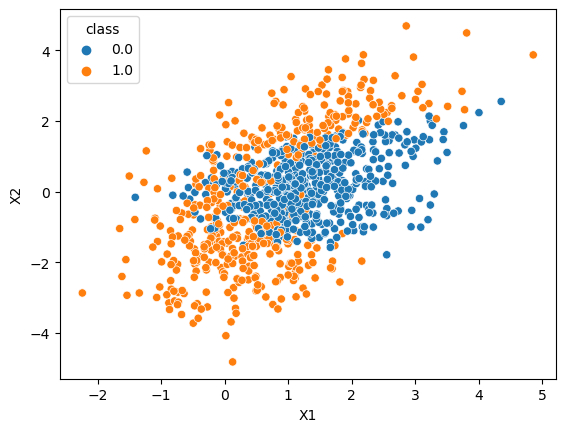

In [7]:
sns.scatterplot(data = simTest, x='X1',y='X2', hue = 'class')

In [8]:
X_train, y_train = simTrain[['X1','X2']], np.array(simTrain['class'])

X_test, y_test = simTest[['X1','X2']], np.array(simTest['class'])

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [10]:
rf_clf = RandomForestClassifier(n_estimators=2000, max_depth=None,random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=2000, random_state=0)

In [11]:
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay

In [13]:
def modelPerf(model, X, y):
    y_true = y
    y_pred = model.predict(X)
    print(f"Report of {model.__class__.__name__}:")
    print(classification_report(y_true, y_pred, digits = 7))
    
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=model.classes_)
    cmdisp.plot(ax = ax1)
    
    y_score = model.predict_proba(X)[:,1]
    roc_area = roc_auc_score(y_true, y_score)
    ax2 = f.add_subplot(122)
    roc_disp = RocCurveDisplay.from_estimator(model, X, y, ax = ax2)
    print(f"The area under the ROC curve is {roc_area}")

Report of RandomForestClassifier:
              precision    recall  f1-score   support

         0.0  0.8586572 0.8983364 0.8780488       541
         1.0  0.8732719 0.8257081 0.8488242       459

    accuracy                      0.8650000      1000
   macro avg  0.8659646 0.8620222 0.8634365      1000
weighted avg  0.8653654 0.8650000 0.8646347      1000

The area under the ROC curve is 0.933464616078512


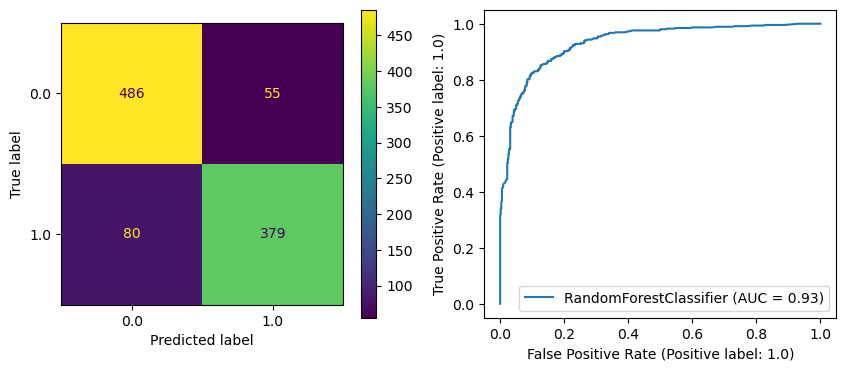

In [14]:
modelPerf(rf_clf, X_test, y_test)

In [15]:
def plotCumulativeGain(X_test, y_test, modelList):
    cg = []
    for model in modelList:
        y_score = model.predict_proba(X_test)[:,1]
        n_samples, n_pos = len(y_test), sum(y_test)
        dfy = pd.DataFrame({'score':y_score,'true': y_test}).sort_values('score',ascending = False)
        dfy['no'] = 1
        dfy['cum_pos'] = dfy['true'].cumsum()/n_pos
        dfy['cum_sample'] = dfy['no'].cumsum()/n_samples
        cg.append(dfy[['cum_pos','cum_sample']])
        
    _, ax=plt.subplots(figsize=(5,3.5))
    for i in range(len(cg)):
        sns.lineplot(cg[i]*100, x= 'cum_sample', y = 'cum_pos',label=modelList[i].__class__.__name__)
    ax.set(xlabel = '% Samples Tested', ylabel = '% Samples Found')  

In [16]:
y_score =  qda_clf.predict_proba(X_test)[:,1]

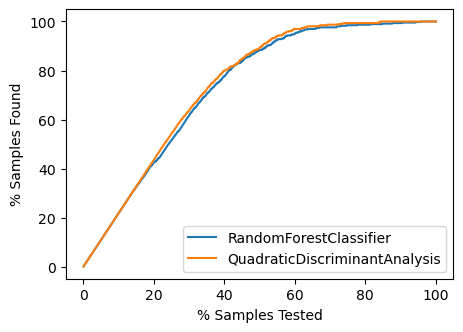

In [17]:
plotCumulativeGain(X_test, y_test, [rf_clf, qda_clf])